# Querying MPC for objects in Allen Fields

## First load the pointing group info

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp

import healpy as hp
import pointing_groups as pg
import requests

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import NoConvergence

from queryMPC import runMPCRequests
from queryMPC import matchSingleVisit
from plottingTools import makeStamps

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [5]:
with open('PickledPointings.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)
    
den_visit,den_ccd,den_stellarnum = np.loadtxt('ref_data.txt',unpack=True)
unique_den_visit = np.unique(den_visit)
max_stellarnum = []
_= [ max_stellarnum.append(np.max(den_stellarnum[den_visit==visit])) for visit in unique_den_visit ]
max_stellarnum = np.array(max_stellarnum)

for i,group in enumerate(Pointing_Groups):
    group_max = np.concatenate([ (max_stellarnum[(unique_den_visit==x)]) for x in np.array(Pointing_Groups[i]["visit_id"],dtype=np.float_) ])
    if not(group_max.size):
        group_max=[-9999.]
    group_max = np.max(group_max)
    Pointing_Groups[i]['stellar_density'] = group_max
    
# visitToIndex is a dictionary that returns the index of a given visit
visitToIndex = {}
for i,pointing in enumerate(Pointing_Groups):
    for visit in pointing['visit_id']:
        visitToIndex[str(visit)] = i

## Set up tools for MPC querying

## Pick a pointing group and get data with `runMPCRequests`

This will query the online MPC database and get a dataframe with all MPC objects within 90 arcminutes of the center of each pointing.

In [6]:
# Get all MPC objects within 90 arcminutes of the pointing group center
pgNum=301 # Pointing Group Number as assigned in NEO_Fields
resultsDF = runMPCRequests(Pointing_Groups[pgNum], str(pgNum))
# Initialize ccd, x_pixel, and y_pixel values
# This prepares the dataframe for the pixel matching
resultsDF['ccd'] = -99
resultsDF['x_pixel'] = -99
resultsDF['y_pixel'] = -99
# Calculate total motion
resultsDF['total_motion'] = np.sqrt(resultsDF['ra_motion']**2. + resultsDF['dec_motion']**2.)
len(resultsDF)

     0433933   2015 04 18.27511 13 28 55.470-09 19 50.20                     W84
     0433937   2015 04 18.27836 13 28 55.450-09 19 48.20                     W84
     0433941   2015 04 18.28164 13 28 55.310-09 19 50.30                     W84
     0433946   2015 04 18.28952 13 28 55.480-09 19 49.30                     W84
     0433950   2015 04 18.29271 13 28 55.750-09 19 45.20                     W84
     0434611   2015 04 19.26658 13 28 55.670-09 19 46.00                     W84
     0434615   2015 04 19.26979 13 28 55.520-09 19 45.80                     W84
     0434619   2015 04 19.27306 13 28 55.860-09 19 47.30                     W84
     0434623   2015 04 19.27627 13 28 55.800-09 19 47.10                     W84
     0434627   2015 04 19.27952 13 28 55.690-09 19 45.00                     W84
     0435499   2015 04 21.26756 13 28 55.270-09 19 56.60                     W84
     0435503   2015 04 21.27088 13 28 55.040-09 19 58.90                     W84
     0435507   2015 04 21.27

0

In [8]:
# Match the objects from MPC with pixel locations in the DECam NEO Survey
# Can comment this out if you don't want to select on slow movers (total_motion is arcsec/hr.)
# Cut the dataframe based on desired brightness and speed
cutDF = resultsDF.query('v_mag > 22 and total_motion < 10')
cutDF = cutDF.reset_index(drop=True)
# Generate a list of visits in the pointing group
nightVisits = np.unique(cutDF['visit_id'])
# Generate the path to the data
dataPath = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/Pointing_Group_{0}/warps/{0}'.format(pgNum)

def matchPixels(visit):
    """This is a wrapper for matchSingleVisit.
    It allows it to easily run in parallel with a simple
    pool.map() call.
    """
    visitDF = cutDF.query('visit_id == %i' % visit)
    visitDF = visitDF.reset_index(drop=True)
    visitDF = matchSingleVisit(visitDF,visit,dataPath)
    print('Processed visit {}'.format(visit))
    return(visitDF)

with mp.Pool(20) as pool:
    results = pool.map(matchPixels,nightVisits)
# Concatenate the results back into a single dataframe.
objectDF = pd.concat(results)

Empty DataFrame
Columns: [visit_id, name, ra_hour, ra_min, ra_sec, dec_deg, dec_min, dec_sec, v_mag, ra_motion, dec_motion, field, ccd, x_pixel, y_pixel, total_motion]
Index: []


ValueError: No objects to concatenate

ValueError: operands could not be broadcast together with shapes (21,21) (5,21) (21,21) 

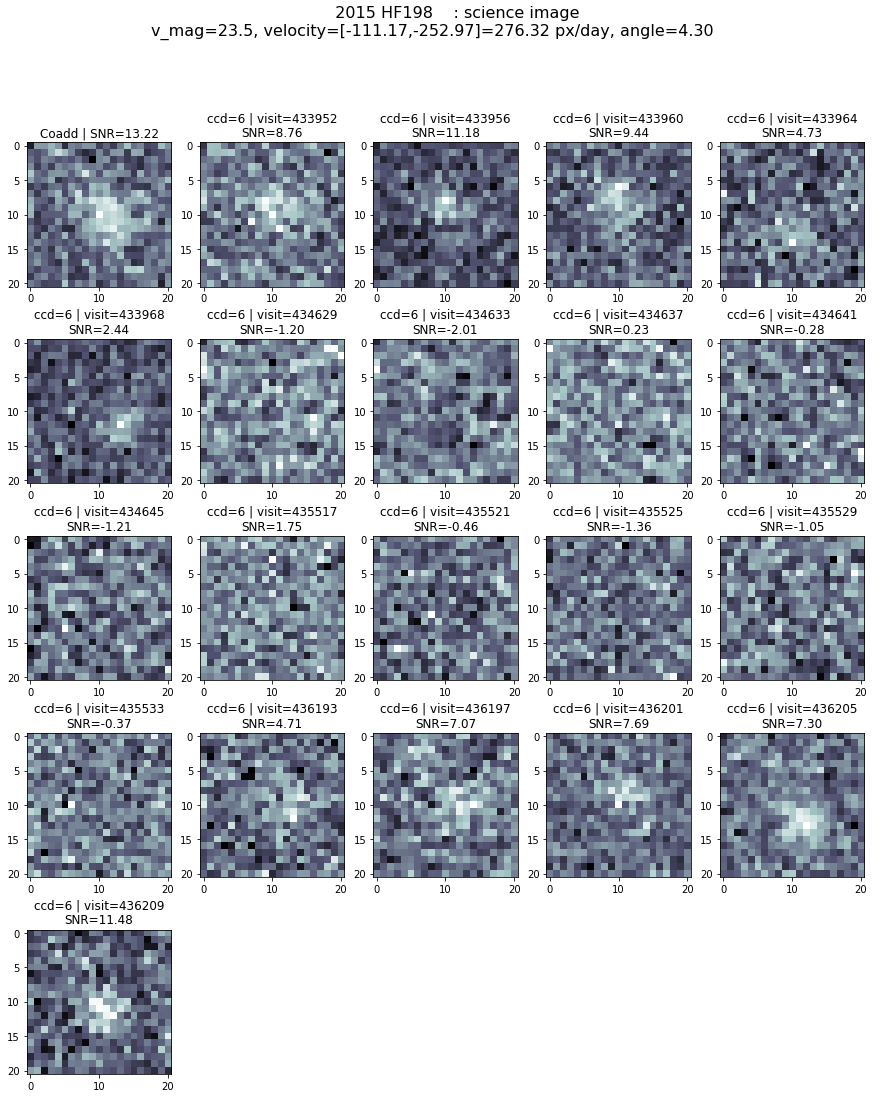

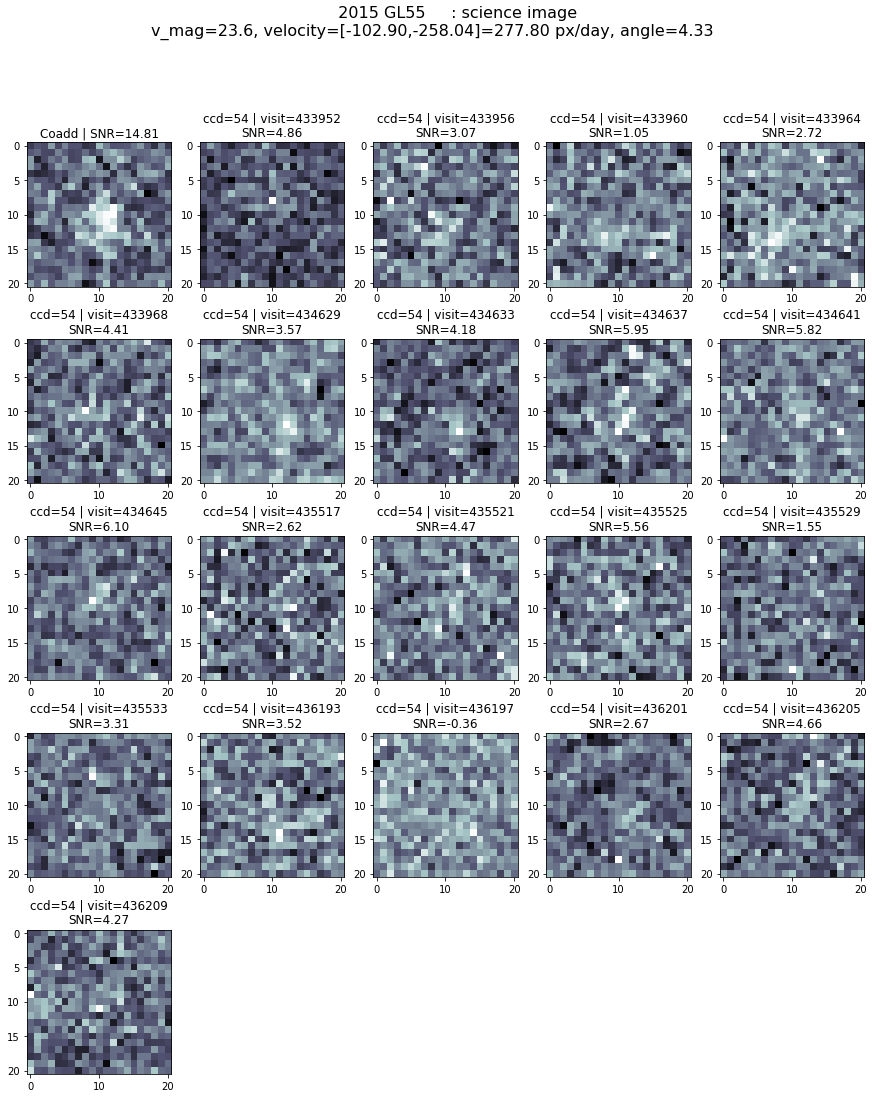

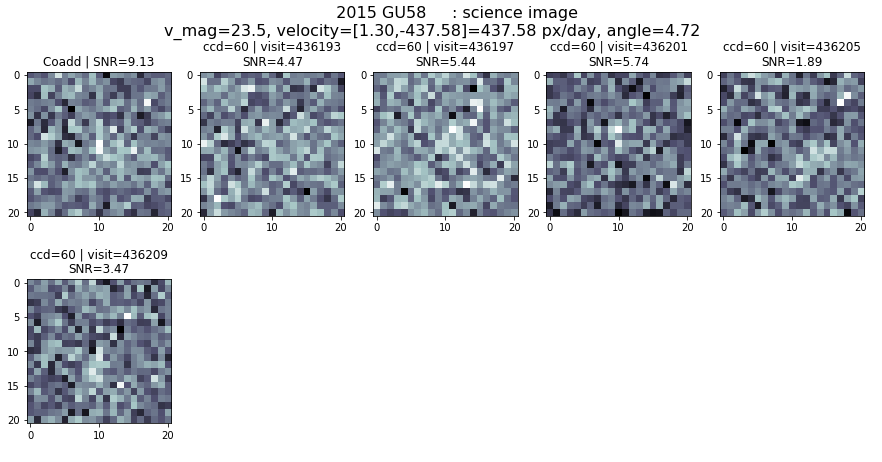

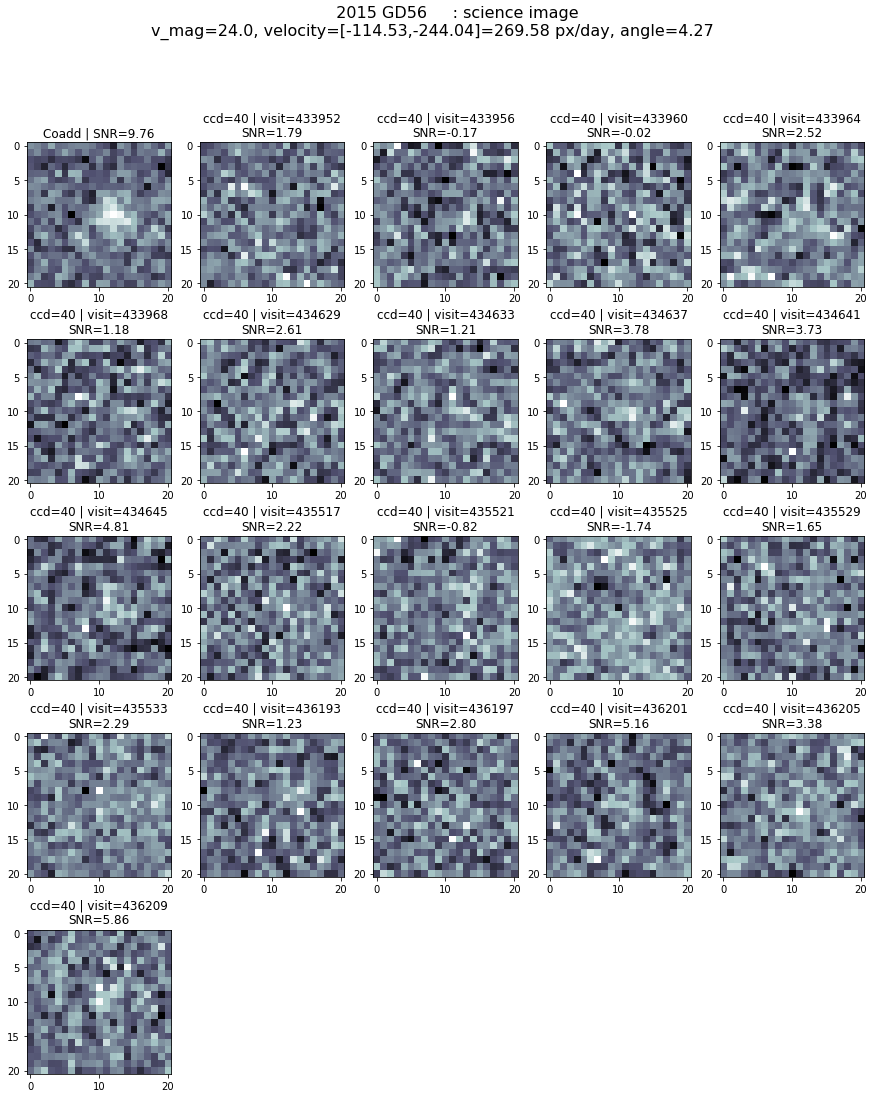

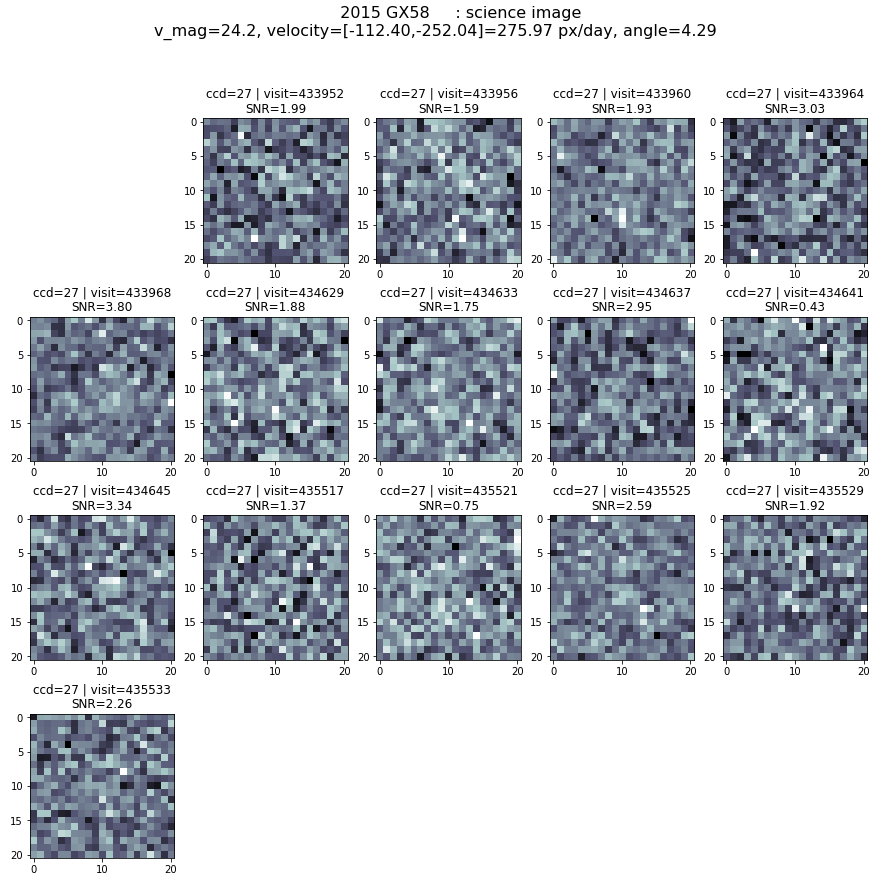

In [13]:
objectDF = objectDF.query('ccd>-1')
filepath = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/Pointing_Group_{0:03}/warps/{0:03}'
# Pointing group number. See PickledPointings.pkl for more info
pgNum=303

# Generate a list of names and sort by magnitude
cutOL = objectDF.drop_duplicates('name')
cutOL = cutOL.sort_values('v_mag')

for name in cutOL['name'].get_values():
    makeStamps(name,objectDF,filepath.format(pgNum),stampSize=[21,21],numCols=5)

,visit_id,name,ra_hour,ra_min,ra_sec,dec_deg,dec_min,dec_sec,v_mag,ra_motion,dec_motion,field,ccd,x_pixel,y_pixel,total_motion
6,433952,2015 HF198,13,36,31.3,-5,40,30,23.3,-5,1,303,6,1272.881992,3839.783365,5.099020
6,433956,2015 HF198,13,36,31.3,-5,40,30,23.3,-5,1,303,6,1272.881992,3839.783365,5.099020
6,433960,2015 HF198,13,36,31.3,-5,40,30,23.3,-5,1,303,6,1272.881992,3839.783365,5.099020
6,433964,2015 HF198,13,36,31.2,-5,40,30,23.3,-4,1,303,6,1272.898596,3834.111606,4.123106
6,433968,2015 HF198,13,36,31.2,-5,40,29,23.3,-4,1,303,6,1269.088264,3834.110164,4.123106
6,434629,2015 HF198,13,36,26.5,-5,39,55,23.3,-4,1,303,6,1140.313245,3567.469823,4.123106
6,434633,2015 HF198,13,36,26.5,-5,39,55,23.3,-4,1,303,6,1140.313245,3567.469823,4.123106
6,434637,2015 HF198,13,36,26.4,-5,39,55,23.4,-4,1,303,6,1140.329760,3561.797636,4.123106
6,434641,2015 HF198,13,36,26.4,-5,39,55,23.4,-4,1,303,6,1140.329760,3561.797636,4.123106
6,434645,2015 HF198,13,36,26.4,-5,39,54,23.4,-4,1,303,6,1136.519272,3561.795711,4.123106


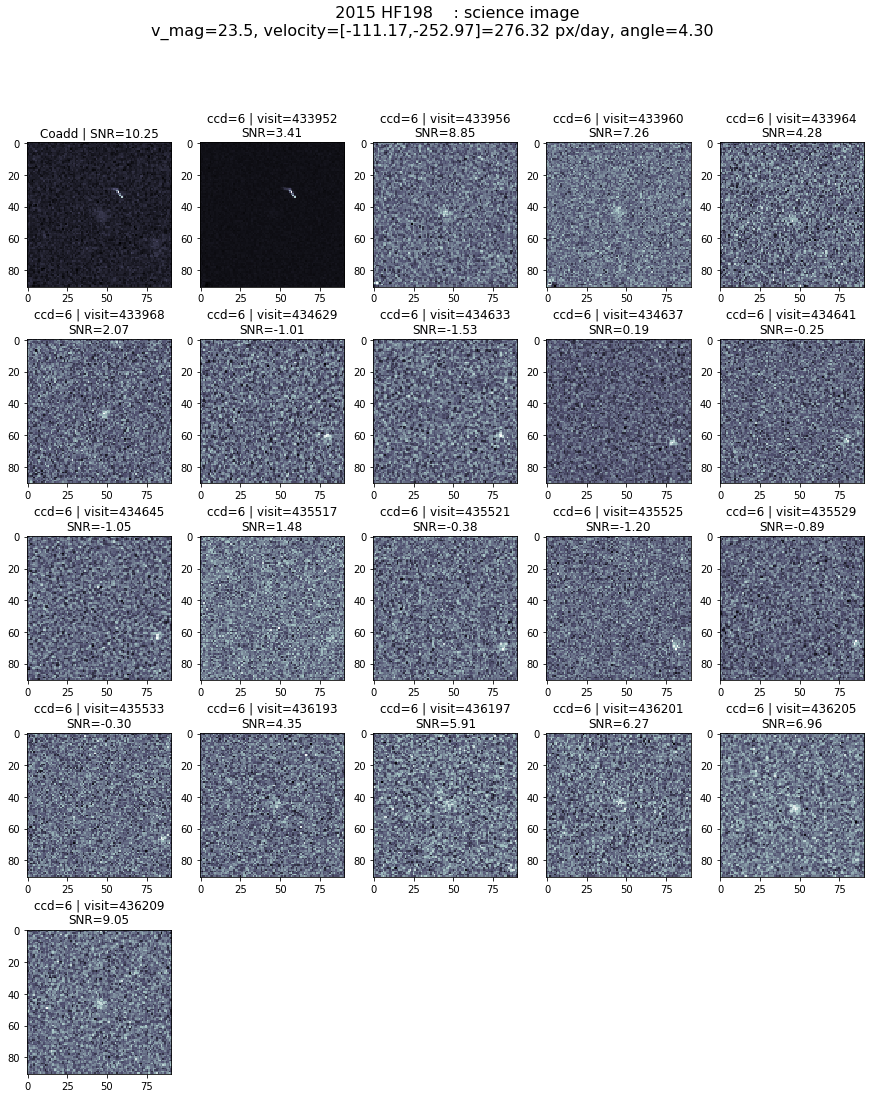

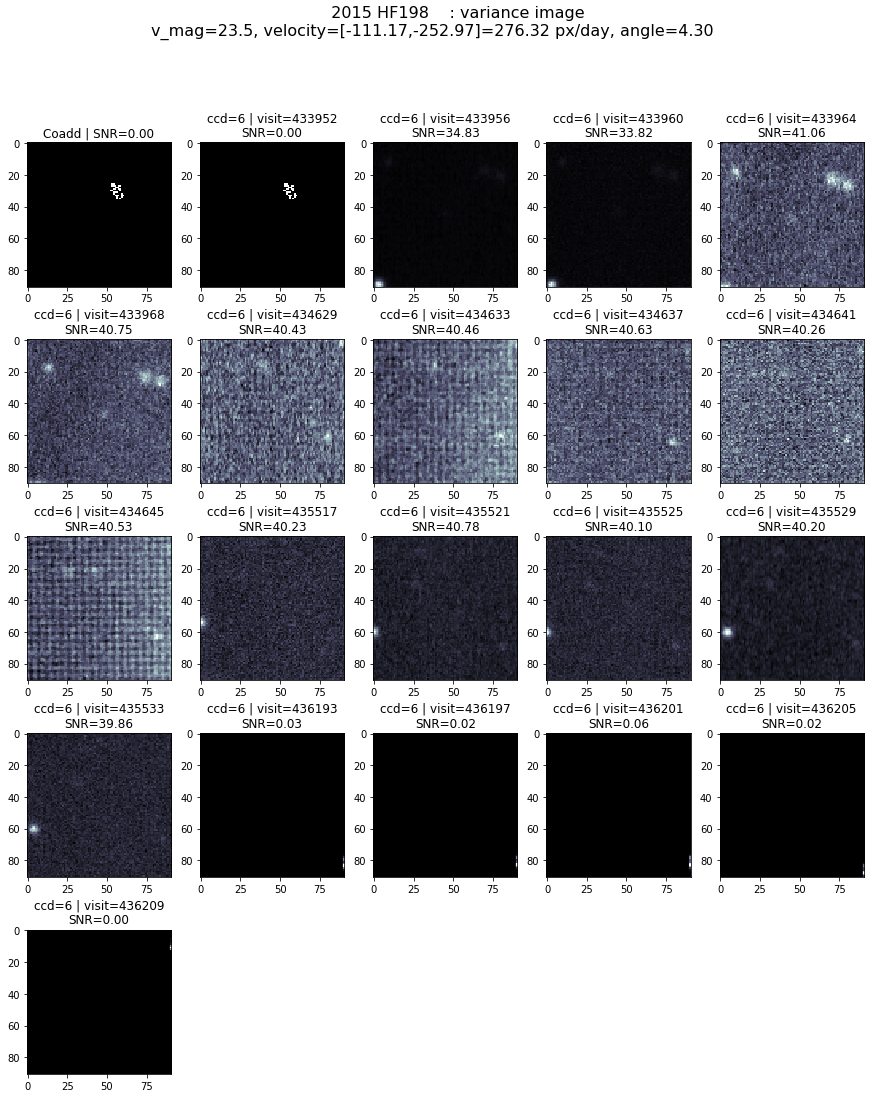

In [31]:
# Generate a list of names and sort by magnitude
size=[91,91]
cutOL = objectDF.drop_duplicates('name')
cutOL = cutOL.sort_values('v_mag')
## Make cuts to the object_list dataframe in order to select the object of interest
cutOL = cutOL.query('v_mag==23.3')
name = cutOL['name'].get_values()[0]
makeStamps(name,objectDF,filepath.format(pgNum),stampSize=size,numCols=5)
#makeStamps(name,objectDF,filepath.format(pgNum),imagePlane='mask',stampSize=size,numCols=5)
makeStamps(name,objectDF,filepath.format(pgNum),imagePlane='variance',stampSize=size,numCols=5)
objectDF.query('name=="{}"'.format(name))


In [8]:
# Write the moving objects to a text file for further analysis
datafile = 'objects300_multi.txt'

init_data = True
for i in range(62):
    full_query = objectDF.query('ccd == '+str(i))
    query = full_query.drop(columns=['ra_hour','ra_min','ra_sec','dec_deg','dec_min','dec_sec','ra_motion','dec_motion'])
    if len(query) > 5:
        if init_data:
            query.to_csv(datafile,sep=',',index=False)
            init_data=False
            with open(datafile,'a') as f:
                f.write('\n')
        else:
            query.to_csv(f,sep=',',header=False,mode='a',index=False)
            with open(datafile,'a') as f:
                f.write('\n')

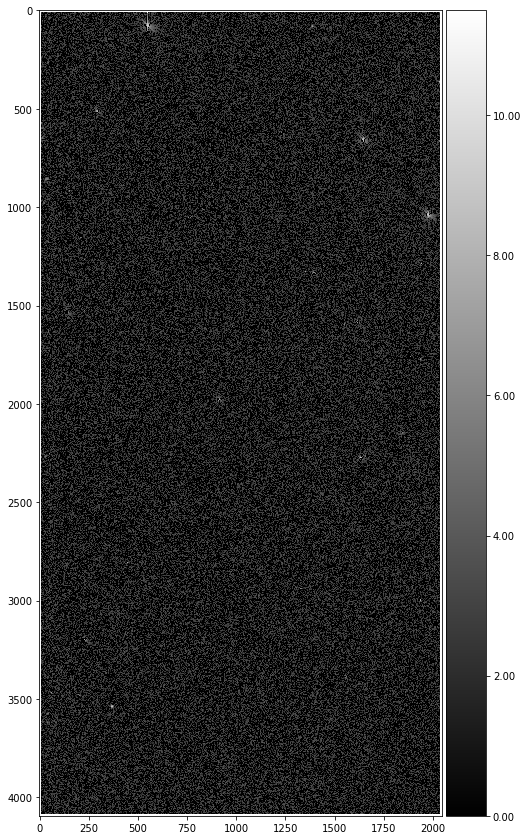

In [22]:
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
ccd=15
visit_id=433932
hdul=fits.open(os.path.join(filepath.format(pgNum),'{:02}/{}.fits'.format(ccd,visit_id)))

# Plot the whole image
fig,ax = plt.subplots(figsize=[8,24])
im = ax.imshow(np.arcsinh(hdul[1].data),cmap=plt.cm.gray,vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, format="%.2f")



In [32]:
from astropy import constants as c
from astropy import units as u

In [55]:
Reflex = 2*constants.R_earth
Distance = 100*u.AU.to(u.m)*u.m
Reflex/Distance*3600/.264

<Quantity 0.03287671>

In [45]:
Reflex

<Quantity 12756200. m>

In [46]:
Distance

<Quantity 5.98391483e+12 m>